#  Prevendo o Nível de Satisfação dos Clientes do Santander

# Definição do Problema de Negócio

### O objetivo deste trabalho é analisar dados de clientes do banco Santander, e assim prever o nível de satisfação dos clientes, 1 para insatisfeitos e 0 para satisfeitos, para identificar os que estão insatisfeitos no início do relacionamento. Isso permitiria ao Santander adotar medidas proativas para melhorar o nível de satisfação de um cliente antes que ele abandone o banco.

## Importando os pacotes necessários

In [1]:
# Imports
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import PCA
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from imblearn.under_sampling import NearMiss
import seaborn as sns
import pandas as pd
import math
from sklearn.metrics import accuracy_score, fbeta_score, recall_score, precision_score, confusion_matrix, make_scorer
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data


sns.set()

In [2]:
spSession = SparkSession.builder.master("local").appName("Projeto_3").getOrCreate()

## Carregando os Dados

In [3]:
train_path='data/train.csv'
df_train=spark.read.load(train_path,format="csv", sep=",",header=True)

In [4]:
df_train.cache() #colocando as dataframes em cache para aumentar a performance

DataFrame[ID: string, var3: string, var15: string, imp_ent_var16_ult1: string, imp_op_var39_comer_ult1: string, imp_op_var39_comer_ult3: string, imp_op_var40_comer_ult1: string, imp_op_var40_comer_ult3: string, imp_op_var40_efect_ult1: string, imp_op_var40_efect_ult3: string, imp_op_var40_ult1: string, imp_op_var41_comer_ult1: string, imp_op_var41_comer_ult3: string, imp_op_var41_efect_ult1: string, imp_op_var41_efect_ult3: string, imp_op_var41_ult1: string, imp_op_var39_efect_ult1: string, imp_op_var39_efect_ult3: string, imp_op_var39_ult1: string, imp_sal_var16_ult1: string, ind_var1_0: string, ind_var1: string, ind_var2_0: string, ind_var2: string, ind_var5_0: string, ind_var5: string, ind_var6_0: string, ind_var6: string, ind_var8_0: string, ind_var8: string, ind_var12_0: string, ind_var12: string, ind_var13_0: string, ind_var13_corto_0: string, ind_var13_corto: string, ind_var13_largo_0: string, ind_var13_largo: string, ind_var13_medio_0: string, ind_var13_medio: string, ind_var13

### Exibe uma amostra dos dados

In [5]:
display(df_train.take(5))

[Row(ID='1', var3='2', var15='23', imp_ent_var16_ult1='0', imp_op_var39_comer_ult1='0', imp_op_var39_comer_ult3='0', imp_op_var40_comer_ult1='0', imp_op_var40_comer_ult3='0', imp_op_var40_efect_ult1='0', imp_op_var40_efect_ult3='0', imp_op_var40_ult1='0', imp_op_var41_comer_ult1='0', imp_op_var41_comer_ult3='0', imp_op_var41_efect_ult1='0', imp_op_var41_efect_ult3='0', imp_op_var41_ult1='0', imp_op_var39_efect_ult1='0', imp_op_var39_efect_ult3='0', imp_op_var39_ult1='0', imp_sal_var16_ult1='0', ind_var1_0='0', ind_var1='0', ind_var2_0='0', ind_var2='0', ind_var5_0='1', ind_var5='0', ind_var6_0='0', ind_var6='0', ind_var8_0='0', ind_var8='0', ind_var12_0='0', ind_var12='0', ind_var13_0='0', ind_var13_corto_0='0', ind_var13_corto='0', ind_var13_largo_0='0', ind_var13_largo='0', ind_var13_medio_0='0', ind_var13_medio='0', ind_var13='0', ind_var14_0='0', ind_var14='0', ind_var17_0='0', ind_var17='0', ind_var18_0='0', ind_var18='0', ind_var19='0', ind_var20_0='0', ind_var20='0', ind_var24_0

## Converte cada coluna para o tipo float

In [6]:
for col in df_train.columns:
    df_train=df_train.withColumn(col, df_train[col].cast(DoubleType()))

## Exibe algumas estatísticas referentes ao dataset

In [7]:
df_train.describe().show()

+-------+-----------------+-------------------+-----------------+------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------+-----------------------+-----------------------+-----------------------+-----------------------+------------------+-----------------------+-----------------------+------------------+------------------+--------------------+--------------------+----------+--------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------

### Obs: A maioria das colunas possui média bem distante da mediana e isso é um indicativo que os dados não seguem uma distribuição normal

# Limpeza dos dados

##  Tratamento de missing values

In [8]:
print('quantidade de amostras antes de remover os valores faltantes:',df_train.count())

quantidade de amostras antes de remover os valores faltantes: 76020


In [9]:
df_train=df_train.dropna()

In [10]:
print('quantidade de amostras depois de remover os valores faltantes:',df_train.count())

quantidade de amostras depois de remover os valores faltantes: 76020


### Obs: Não existem missing values para esse dataset

## Remoção de Duplicatas

In [11]:
print('quantidade de amostras antes de remover as duplicatas:',df_train.count())

quantidade de amostras antes de remover as duplicatas: 76020


In [12]:
df_train=df_train.drop_duplicates()

In [13]:
print('quantidade de amostras depois de remover as duplicatas:',df_train.count())

quantidade de amostras depois de remover as duplicatas: 76020


### Obs: Não existem duplicatas para esse dataset

## Verificando se o Dataset está Balanceado

In [14]:
df_train.groupBy('TARGET').count().show()

+------+-----+
|TARGET|count|
+------+-----+
|   0.0|73012|
|   1.0| 3008|
+------+-----+



### Obs: O Dataset está bastante desbalanceado, existem poucos casos de clientes insatisfeitos em relação ao total

## Análise de Correlação

In [97]:
# Correlação entre a variável target e as demais variáveis
for i in df_train.columns:
    print( "Correlação da variável TARGET com", i, df_train.stat.corr('TARGET',i))

Correlação da variável TARGET com ID 0.0031484687226994135
Correlação da variável TARGET com var3 0.004474798175536688
Correlação da variável TARGET com var15 0.10132209856071656
Correlação da variável TARGET com imp_ent_var16_ult1 -1.7460253766320422e-05
Correlação da variável TARGET com imp_op_var39_comer_ult1 0.010353129575421526
Correlação da variável TARGET com imp_op_var39_comer_ult3 0.0035169224416894125
Correlação da variável TARGET com imp_op_var40_comer_ult1 0.0031193869489657927
Correlação da variável TARGET com imp_op_var40_comer_ult3 -0.0003578690699806947
Correlação da variável TARGET com imp_op_var40_efect_ult1 0.01922144928852703
Correlação da variável TARGET com imp_op_var40_efect_ult3 0.01996520675479912
Correlação da variável TARGET com imp_op_var40_ult1 0.0030872912147492004
Correlação da variável TARGET com imp_op_var41_comer_ult1 0.010082404008577801
Correlação da variável TARGET com imp_op_var41_comer_ult3 0.003858586978332247
Correlação da variável TARGET com im

Correlação da variável TARGET com num_op_var40_ult1 0.0014205816899547992
Correlação da variável TARGET com num_op_var40_ult3 -0.00011901201310435186
Correlação da variável TARGET com num_op_var41_hace2 0.007619298817911783
Correlação da variável TARGET com num_op_var41_hace3 -0.0011949275362012055
Correlação da variável TARGET com num_op_var41_ult1 0.01124164505367729
Correlação da variável TARGET com num_op_var41_ult3 0.010461674068047183
Correlação da variável TARGET com num_op_var39_hace2 0.007185348347176046
Correlação da variável TARGET com num_op_var39_hace3 -0.0013515233930702238
Correlação da variável TARGET com num_op_var39_ult1 0.011246031183984508
Correlação da variável TARGET com num_op_var39_ult3 0.01027090602464659
Correlação da variável TARGET com num_var27_0 nan
Correlação da variável TARGET com num_var28_0 nan
Correlação da variável TARGET com num_var28 nan
Correlação da variável TARGET com num_var27 nan
Correlação da variável TARGET com num_var29_0 -0.002082311545268

Correlação da variável TARGET com imp_reemb_var17_ult1 0.00890907593211063
Correlação da variável TARGET com imp_reemb_var33_hace3 nan
Correlação da variável TARGET com imp_reemb_var33_ult1 -0.0007361744104648012
Correlação da variável TARGET com imp_var43_emit_ult1 -0.004261113825499585
Correlação da variável TARGET com imp_trans_var37_ult1 -0.01092815590562943
Correlação da variável TARGET com imp_trasp_var17_in_hace3 -0.0009801568973627846
Correlação da variável TARGET com imp_trasp_var17_in_ult1 -0.0010020522439791945
Correlação da variável TARGET com imp_trasp_var17_out_hace3 nan
Correlação da variável TARGET com imp_trasp_var17_out_ult1 -0.0010867719583534375
Correlação da variável TARGET com imp_trasp_var33_in_hace3 -0.0017487085588557825
Correlação da variável TARGET com imp_trasp_var33_in_ult1 -0.0011960136398964213
Correlação da variável TARGET com imp_trasp_var33_out_hace3 nan
Correlação da variável TARGET com imp_trasp_var33_out_ult1 -0.0007361744104648015
Correlação da var

Correlação da variável TARGET com saldo_medio_var13_largo_hace3 -0.007005241143980039
Correlação da variável TARGET com saldo_medio_var13_largo_ult1 -0.012134575077198917
Correlação da variável TARGET com saldo_medio_var13_largo_ult3 -0.012270143775646957
Correlação da variável TARGET com saldo_medio_var13_medio_hace2 -0.0010277576039490117
Correlação da variável TARGET com saldo_medio_var13_medio_hace3 nan
Correlação da variável TARGET com saldo_medio_var13_medio_ult1 -0.0009166686799414157
Correlação da variável TARGET com saldo_medio_var13_medio_ult3 -0.0009520629897784425
Correlação da variável TARGET com saldo_medio_var17_hace2 -0.001202255444284876
Correlação da variável TARGET com saldo_medio_var17_hace3 -0.0008593602909916277
Correlação da variável TARGET com saldo_medio_var17_ult1 -0.0005825814801326757
Correlação da variável TARGET com saldo_medio_var17_ult3 -0.00032758746581767334
Correlação da variável TARGET com saldo_medio_var29_hace2 -0.0010341425774526734
Correlação da 

### Balanceando as Classes

### Utiliza o método NearMiss para igualar a quantidade entre as classes, reduzindo amostras da classe majoritária

In [98]:
X=df_train.toPandas().drop('TARGET',axis=1)
Y=df_train.toPandas()['TARGET']
bal = NearMiss()
#bal = SMOTE()
X, Y = bal.fit_sample(X, Y)

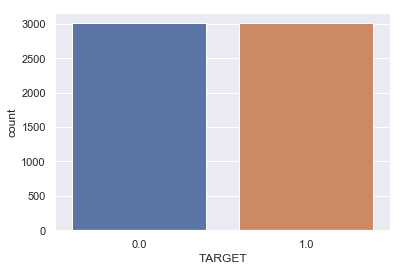

In [99]:
ax = sns.countplot(x=Y)

In [100]:
balanced_data=spSession.createDataFrame(pd.concat([X,Y],axis=1))

In [101]:
balanced_data.count()

6016

### Obs:Agora as Classes estão Balanceadas, Exemplos Iguais de Ambas as Classes

## Pré-processamento

In [105]:
# Criando um LabeledPoint (target, Vector[features])
def transformaVar(row) :
    obj = (row["TARGET"], Vectors.dense(row[:-1]))
    return obj

In [106]:
rdd_train2 = balanced_data.rdd.map(transformaVar)

In [108]:
rdd_train2.take(1)

[(0.0,
  DenseVector([148110.0, 2.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 99

In [109]:
df_train_2 = spSession.createDataFrame(rdd_train2,["label", "features"])

In [110]:
df_train_2.select("features", "label").show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[148110.0,2.0,31....|  0.0|
|[125452.0,2.0,39....|  0.0|
|[61117.0,2.0,26.0...|  0.0|
|[103805.0,2.0,23....|  0.0|
|[61106.0,2.0,25.0...|  0.0|
|[82312.0,2.0,36.0...|  0.0|
|[62762.0,2.0,23.0...|  0.0|
|[103809.0,2.0,25....|  0.0|
|[82277.0,2.0,35.0...|  0.0|
|[82318.0,2.0,26.0...|  0.0|
+--------------------+-----+
only showing top 10 rows



### Aplicando PCA para reduzir a dimensionalidade do Dataset

In [111]:
# Aplicando Redução de Dimensionalidade com PCA
trans_PCA = PCA(k = 50,inputCol = "features", outputCol = "pcaFeatures")
pcaModel = trans_PCA.fit(df_train_2)
pca_train1 = pcaModel.transform(df_train_2)
#pca_test1 = pcaModel.transform(df_test_scaled)
pca_train1.show(truncate = False)

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Separando os Dados em Treino e Testes

In [112]:
# Indexação é pré-requisito para Decision Trees
stringIndexer = StringIndexer(inputCol = "label", outputCol = "indexed")
si_model = stringIndexer.fit(pca_train1)
obj_final = si_model.transform(pca_train1)
obj_final.collect()

[Row(label=0.0, features=DenseVector([148110.0, 2.0, 31.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [113]:
# Dados de Treino e de Teste
(dados_treino, dados_teste) = obj_final.randomSplit([0.75, 0.25])

In [114]:
dados_treino.count()

4492

In [115]:
dados_teste.count()

1524

## Modelagem Preditiva

### Random Forest

In [116]:
# Criando o modelo
rfClassifer = RandomForestClassifier(labelCol = "indexed", featuresCol = "pcaFeatures")
modelo = rfClassifer.fit(dados_treino)

In [121]:
# Previsões com dados de teste
predictions = modelo.transform(dados_teste)
predictions.select("prediction", "indexed", "label", "pcaFeatures").collect()

[Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector([-5.3424, 0.8454, -0.9156, 0.4688, 117383.1861, -2601.7476, 457.4452, -1284.0198, -98.9497, 248.7525, 383.0193, -19.1417, 225.6649, -157.4182, -52.619, -156.3546, -21.6062, 306.7798, 98.256, 80.5977, 243.7161, 17.2015, 186.3413, 57.6089, -30.7593, -60.7226, -14.7143, -10.3367, 22.236, 7.9233, -4.1415, -8.0744, 4.7347, -31.1404, 8.5248, 2.3585, -10.6054, 1.726, 0.8503, 2.7401, 27.4279, 0.447, 0.8928, -1.2338, -3.9052, -26.0416, 0.8803, 4.9415, 0.3151, 3.2919])),
 Row(prediction=0.0, indexed=0.0, label=0.0, pcaFeatures=DenseVector([-5.3424, 0.8454, -0.9156, 0.4689, 117383.4243, -2612.7432, 457.3429, -1283.9961, -99.0403, 248.7002, 382.9823, -18.9901, 224.3796, -157.6886, -52.9834, -156.5877, -21.4158, 307.0539, 98.2408, 81.01, 243.0766, 17.1784, 186.9556, 55.81, -30.5711, -60.364, -14.6348, -10.5285, 22.2733, 7.9027, -4.0881, -8.0561, 4.5987, -31.263, 8.6018, 2.3319, -10.5774, 1.6906, 0.7208, 2.7368, 27.5918, 0.4303, 0.

### Avaliando o Modelo

In [122]:
# Avaliando a acurácia
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction", labelCol = "indexed", metricName = "accuracy")
evaluator.evaluate(predictions)      

0.8969816272965879

In [123]:
# Confusion Matrix
predictions.groupBy("indexed", "prediction").count().show()

+-------+----------+-----+
|indexed|prediction|count|
+-------+----------+-----+
|    1.0|       1.0|  612|
|    0.0|       1.0|    3|
|    1.0|       0.0|  154|
|    0.0|       0.0|  755|
+-------+----------+-----+



In [124]:
predictions_final=predictions.select("prediction").toPandas().values
y_test=predictions.select("indexed").toPandas()

In [125]:
beta=10 # favorece mais o recall
accuracy=accuracy_score(y_test.values, predictions_final)
fB_score=fbeta_score(y_test.values, predictions_final,beta,average='binary') #[None, 'micro', 'macro', 'weighted', 'samples']
recall_score=recall_score(y_test.values, predictions_final, average='binary')
precision_score=precision_score(y_test.values, predictions_final, average='binary')
tn, fp, fn, tp=confusion_matrix(y_test.values, predictions_final).ravel()

print('Acurácia para o conjunto de testes para a floresta aleatória: {:.3f}  %'.format(accuracy*100))
print('F10 Score para o conjunto de testes para a floresta aleatória: {:.3f}  %'.format(fB_score*100))
print('Recall(sensibilidade) para o conjunto de testes para a floresta aleatória: {:.3f}  %'.format(recall_score*100))
print('Precisão para o conjunto de testes para a floresta aleatória: {:.3f}  %'.format(precision_score*100))
print('Verdadeiros negativos para o conjunto de floresta aleatória: {0}'.format(tn))
print('Falsos positivos para o conjunto de testes para a floresta aleatória: {0}'.format(fp))
print('Falsos negativos para o conjunto de testes para a floresta aleatória: {0}'.format(fn))
print('Verdadeiros positivos para o conjunto de testes para a floresta aleatória: {0}'.format(tp))

Acurácia para o conjunto de testes para a floresta aleatória: 89.698  %
F10 Score para o conjunto de testes para a floresta aleatória: 80.052  %
Recall(sensibilidade) para o conjunto de testes para a floresta aleatória: 79.896  %
Precisão para o conjunto de testes para a floresta aleatória: 99.512  %
Verdadeiros negativos para o conjunto de floresta aleatória: 755
Falsos positivos para o conjunto de testes para a floresta aleatória: 3
Falsos negativos para o conjunto de testes para a floresta aleatória: 154
Verdadeiros positivos para o conjunto de testes para a floresta aleatória: 612


C:\Users\italo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass beta=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


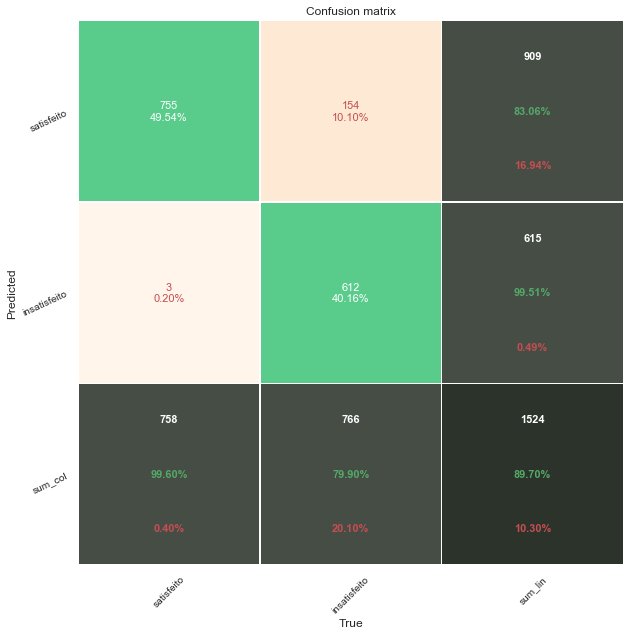

In [126]:
plot_confusion_matrix_from_data(y_test.values, predictions_final, columns=['satisfeito','insatisfeito'], annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[2,2], show_null_values=0, pred_val_axis='lin')